In [274]:
from datetime import datetime
import itertools
import json

import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import torch
from torch.utils.data import DataLoader

from database import data_utils, data_loader, shape_utils
from models import basic_ff
import run_models

importlib.reload(data_utils)
importlib.reload(basic_ff)
importlib.reload(data_loader)

<module 'database.data_loader' from '/Users/zack/Desktop/valle/src/database/data_loader.py'>

In [82]:
overwrite=True
run_name="3_mo_cross_val"
network_name="kcm"
gtfs_folder="../data/kcm_gtfs/2021_10_14/"
raw_data_folder="../data/kcm_all/"
timezone="America/Los_Angeles"
given_names=['tripid','file','locationtime','lat','lon','vehicleid']
train_dates=data_utils.get_date_list("2022_01_01", 31)
test_dates=data_utils.get_date_list("2022_02_01", 7)
n_folds=10

In [279]:
### Load data from raw bus data files
print("="*30)
print(f"Combining raw bus data files...")
# Get traces from all data
train_data, train_fail_dates = data_utils.combine_pkl_data(raw_data_folder, train_dates, given_names)
test_data, test_fail_dates = data_utils.combine_pkl_data(raw_data_folder, test_dates, given_names)
print(f"Lost dates train: {train_fail_dates}, {len(train_data)} samples kept.")
print(f"Lost dates test: {test_fail_dates}, {len(test_data)} samples kept.")

# Load the GTFS
print(f"Loading and merging GTFS files from '{gtfs_folder}'...")
gtfs_data = data_utils.merge_gtfs_files(gtfs_folder)

# Calculate distance between points in each trajectory, do some filtering on speed, n_points
print(f"Calculating trace trajectories, filtering on speed and number of trajectory points...")
train_traces = data_utils.calculate_trace_df(train_data, timezone)
test_traces = data_utils.calculate_trace_df(test_data, timezone)
print(f"Cumulative {np.round(len(train_traces) / len(train_data) * 100, 1)}% of train data retained.")
print(f"Cumulative {np.round(len(test_traces) / len(test_data) * 100, 1)}% of test data retained.")

# Match trajectories to timetables and do filtering on stop distance, availability
print(f"Matching traces to GTFS timetables, filtering on nearest scheduled stop distance, schedule availability...")
train_traces = data_utils.clean_trace_df_w_timetables(train_traces, gtfs_data)
test_traces = data_utils.clean_trace_df_w_timetables(test_traces, gtfs_data)
print(f"Cumulative {np.round(len(train_traces) / len(train_data) * 100, 1)}% of train data retained. Saving {len(train_traces)} samples.")
print(f"Cumulative {np.round(len(test_traces) / len(test_data) * 100, 1)}% of test data retained. Saving {len(test_traces)} samples.")

# Shingle each trajectory into a subset of smaller chunks, drop chunks with 1 point
print(f"Shingling traces into smaller chunks...")
train_traces = data_utils.shingle(train_traces, 2, 8)
test_traces = data_utils.shingle(test_traces, 2, 8)
print(f"Cumulative {np.round(len(train_traces) / len(train_data) * 100, 1)}% of train data retained. Saving {len(train_traces)} samples.")
print(f"Cumulative {np.round(len(test_traces) / len(test_data) * 100, 1)}% of test data retained. Saving {len(test_traces)} samples.")

# Get unique vehicle ids
(train_traces, test_traces), n_unique_veh = data_utils.remap_vehicle_ids([train_traces, test_traces])
print(f"Found {n_unique_veh} unique vehicle IDs in this data.")

Combining raw bus data files...
Lost dates train: ['2022_01_01.pkl', '2022_01_03.pkl', '2022_01_05.pkl', '2022_01_06.pkl', '2022_01_07.pkl', '2022_01_11.pkl', '2022_01_13.pkl'], 436755 samples kept.
Lost dates test: [], 173566 samples kept.
Loading and merging GTFS files from '../data/kcm_gtfs/2021_10_14/'...
Calculating trace trajectories, filtering on speed and number of trajectory points...
Cumulative 46.6% of train data retained.
Cumulative 51.8% of test data retained.
Matching traces to GTFS timetables, filtering on nearest scheduled stop distance, schedule availability...
Cumulative 44.4% of train data retained. Saving 193720 samples.
Cumulative 49.2% of test data retained. Saving 85438 samples.
Shingling traces into smaller chunks...
Cumulative 44.0% of train data retained. Saving 192300 samples.
Cumulative 48.9% of test data retained. Saving 84940 samples.
Found 1132 unique vehicle IDs in this data.


<AxesSubplot: xlabel='tt', ylabel='Count'>

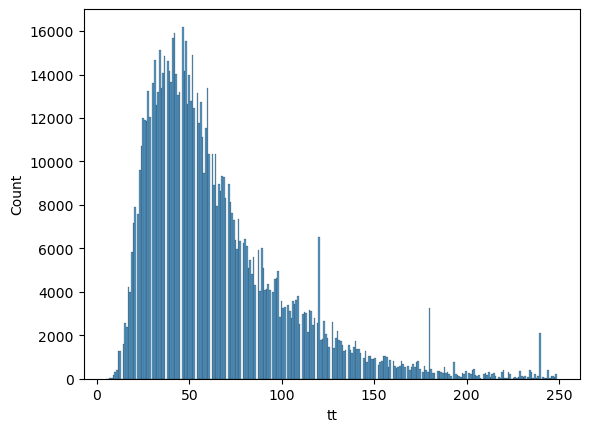

In [281]:
# Histogram of bus travel times in schedule
gtfs_data['arrival_s_prev'] = gtfs_data.groupby('trip_id').shift()[['arrival_s']]
gtfs_data_times = gtfs_data[['arrival_s','arrival_s_prev']].dropna()
gtfs_data_times['tt'] = gtfs_data_times['arrival_s'] - gtfs_data_times['arrival_s_prev']
# Time between bus stops
sns.histplot(gtfs_data_times.loc[gtfs_data_times['tt']<250, 'tt'])

<AxesSubplot: xlabel='lat', ylabel='Count'>

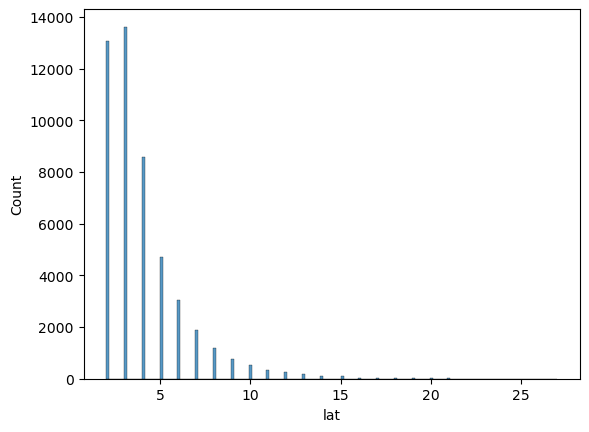

In [283]:
# Points per trajectory
sns.histplot(train_traces.groupby(['shingle_id']).count()['lat'])

In [284]:
train_traces

,trip_id,file,locationtime,lat,lon,vehicle_id,speed_m_s,dist_calc_m,time_calc_s,dist_calc_km,...,timeID,timeID_s,stop_dist_km,stop_arrival_s,stop_lon,stop_lat,trip_start_timeID_s,scheduled_time_s,shingle_id,vehicle_id_recode
0,478065569,2022_01_02.pkl,1641128355,47.401463,-122.297646,6105.0,1.592291,46.176435,29.0,0.046176,...,299,17955,0.116763,18960,-122.287933,47.464027,17955,1005,0,1093
1,478065569,2022_01_02.pkl,1641128401,47.408894,-122.298058,6105.0,9.649471,443.875669,46.0,0.443876,...,300,18001,0.116763,18960,-122.287933,47.464027,17955,1005,0,1093
2,478065569,2022_01_02.pkl,1641128454,47.414848,-122.297264,6105.0,6.879754,364.626941,53.0,0.364627,...,300,18054,0.116763,18960,-122.287933,47.464027,17955,1005,0,1093
3,478065569,2022_01_02.pkl,1641128472,47.414902,-122.297256,6105.0,0.182475,3.284542,18.0,0.003285,...,301,18072,0.116763,18960,-122.287933,47.464027,17955,1005,0,1093
4,478065569,2022_01_02.pkl,1641128560,47.423382,-122.296181,6105.0,21.575930,517.822327,24.0,0.517822,...,302,18160,0.116763,18960,-122.287933,47.464027,17955,1005,1,1093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193715,548860149,2022_01_31.pkl,1643635487,47.599755,-122.302227,8047.0,0.108194,3.462211,32.0,0.003462,...,324,19487,0.171261,21000,-122.313721,47.664974,19222,1778,49847,987
193716,548860149,2022_01_31.pkl,1643635571,47.601830,-122.302380,8047.0,2.963131,124.451522,42.0,0.124452,...,326,19571,0.171261,21000,-122.313721,47.664974,19222,1778,49848,987
193717,548860149,2022_01_31.pkl,1643635644,47.606373,-122.302780,8047.0,3.748282,273.624594,73.0,0.273625,...,327,19644,0.171261,21000,-122.313721,47.664974,19222,1778,49848,987
193718,548860149,2022_01_31.pkl,1643635709,47.608489,-122.302765,8047.0,1.934375,125.734374,65.0,0.125734,...,328,19709,0.171261,21000,-122.313721,47.664974,19222,1778,49849,987
